# Подготовка и обогащение данных, EDA

Тетрадка содержит предобработку данных и дополнение исходного набора дополнительными признаками: экономическими данными (экономические индексы, курс доллара и т.п.), данными о погоде, о заболеваемости коронавирусом, внешними данными (тексты статей и проч, распарсенные с сайта РБК). Также в тетрадку включены некоторые элементы из исследовательского анализа данных

Внимание: на ОС Windows лемматизатор pymystem3 может работать аномально долго, это известный баг. На MacOS тетрадка отрабатывает целиком примерно за 10 минут

In [1]:
%load_ext autoreload
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

from pymystem3 import Mystem

import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

from IPython.display import display

from rbk.utils.global_vars import \
    RANDOM_STATE, ROOT_ABSPATH, RAW_DATA_PATH,\
        PARSED_DATA_PATH, PARSED_FILENAME,\
            TRAIN_FILENAME, TEST_FILENAME,\
                PREPARED_DATA_PATH

from rbk.utils import helpers, prepare_data, text_processing

pd.set_option('display.max_columns', None)
tqdm.pandas()

# Грузим данные и добавляем признаки

In [3]:
%autoreload 2
# если вдруг пикл не грузится из-за конфликта версий, нужно установить версию питона 3.9.4
parsed_data = helpers.load_pickle(os.path.join(ROOT_ABSPATH, PARSED_DATA_PATH, PARSED_FILENAME))

df_train = pd.read_csv(os.path.join(ROOT_ABSPATH, RAW_DATA_PATH, TRAIN_FILENAME), index_col=0)
df_test = pd.read_csv(os.path.join(ROOT_ABSPATH, RAW_DATA_PATH, TEST_FILENAME), index_col=0)

display(df_train.head(2))
display(df_train.tail(2))

df_train = prepare_data.preprocess_extend_raw_data (df_train, parsed_data)
df_test = prepare_data.preprocess_extend_raw_data (df_test, parsed_data)

display(df_train.head(2))
display(df_train.tail(2))

,title,publish_date,session,authors,ctr,category,tags,views,depth,full_reads_percent
document_id,,,,,,,,,,
624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,Европейский банк развития приостановил доступ ...,2022-04-04 10:29:44,IDE7mtH4RBqGn-8MXfGffQ,[],1.580,5409f11ce063da9c8b588a18,"['55928d339a794751dc8303d6', '542d1e28cbb20f86...",20460,1.134,35.850
620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,Кремль назвал регулярным процессом учебные зап...,2022-02-18 10:00:39,KtVJsteHStO5oditt3Uvzw,"['54244e01cbb20f03076b236d','5878a2ec9a7947e53...",1.853,5409f11ce063da9c8b588a12,"['549d25df9a794775979561d2', '58abcf539a7947f1...",19038,1.142,38.355


,title,publish_date,session,authors,ctr,category,tags,views,depth,full_reads_percent
document_id,,,,,,,,,,
627303699a794749b8116abc12JX_3ZDTDu2XHF3k2eJVg,Экс-посол Франции назвал болезненным для Европ...,2022-05-04 23:15:48,12JX_3ZDTDu2XHF3k2eJVg,[],0.000,5409f11ce063da9c8b588a13,"['59cd72769a7947ba5f3a8ae5', '5409f15ae063daa0...",3450,1.068,38.928
627f1c089a794743b070ff73hVvdVmFxS2SlZ2_lECDEow,Минфин США предостерег зарубежные банки от пом...,2022-05-14 03:41:33,hVvdVmFxS2SlZ2_lECDEow,['5edf68259a79470758e7ab2d'],2.937,5409f11ce063da9c8b588a12,"['5409f15ee063daa0f408adb0', '5463e5b9cbb20f87...",11981,1.072,36.249


Обрабатываем session
Обрабатываем category
Обрабатываем title
Обрабатываем theme
Обрабатываем data_category_parsed
Обрабатываем datetime_parsed
Обрабатываем title_parsed
Обрабатываем description_parsed
Обрабатываем keywords_parsed
Обрабатываем copyright_parsed
Обрабатываем url_parsed
Обрабатываем yandex_recommendations_category_parsed
Обрабатываем article_header_yandex_parsed
Обрабатываем article_text_parsed
Обрабатываем session
Обрабатываем category
Обрабатываем title
Обрабатываем theme
Обрабатываем data_category_parsed
Обрабатываем datetime_parsed
Обрабатываем title_parsed
Обрабатываем description_parsed
Обрабатываем keywords_parsed
Обрабатываем copyright_parsed
Обрабатываем url_parsed
Обрабатываем yandex_recommendations_category_parsed
Обрабатываем article_header_yandex_parsed
Обрабатываем article_text_parsed


,publish_date,session,authors,ctr,category,tags,views,depth,full_reads_percent,title,local_hour,views_parsed,data_category_parsed,title_parsed,description_parsed,keywords_parsed,url_parsed,yandex_recommendations_category_parsed,tags_parsed,article_text_parsed,authors_parsed,publish_date_parsed,hour,day,weekday,days_from_collecting,days_from_parsing,publish_date_mismatch_days,url_id,url_id_count,session_count,brent,brent_grows,brent_std_7d,brent_grows_7d,dax,dax_grows,dax_std_7d,dax_grows_7d,ftse,ftse_grows,ftse_std_7d,ftse_grows_7d,gold_gcq2,gold_gcq2_grows,gold_gcq2_std_7d,gold_gcq2_grows_7d,irts,irts_grows,irts_std_7d,irts_grows_7d,nasdaq,nasdaq_grows,nasdaq_std_7d,nasdaq_grows_7d,nikkei,nikkei_grows,nikkei_std_7d,nikkei_grows_7d,sp500,sp500_grows,sp500_std_7d,sp500_grows_7d,usd_rub,usd_rub_grows,usd_rub_std_7d,usd_rub_grows_7d,key_rate,inflation,new_cases_per_million_OWID_EUN,new_deaths_per_million_OWID_EUN,new_cases_per_million_RUS,new_deaths_per_million_RUS,new_cases_per_million_USA,new_deaths_per_million_USA,temperature,pressure,air_humidity,wind_speed,rainfall,article_len,title_len,url_depth,authors_counts,tags_counts
document_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55c3984d9a79470f2c260465BKmAn_fHQruT38beqDIE_A,2017-08-07 13:00:27,BKmAn_fHQruT38beqDIE_A,[57c3fa919a7947e69071e942],1.422,5433e5decbb20f277b20eca9,"[5409f144e063daa0f408ad26, 5409f3ade063daa0f40...",6238,1.067,54.489,Развод на миллионы: как российские бизнесмены ...,NaN,297573.0,Общество,Развод на миллионы: как российские бизнесмены ...,"19 мая стало известно, что Алишер Усманов пода...","Известный, Бизнесмен, Назначить, Процесс, Росс...",https://www.rbc.ru/photoreport/19/05/2022/55c3...,Общество,"[мультимедиа, Фотогалерея]","19 мая стало известно, что Алишер Усманов пода...","[Юлия Сапронова, Алексей Гаврилко-Алексеев]",2022-05-19 14:37:22,13,7,0,1757,1787,1746,55c3984d9a79470f2c260465,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6114,66,8,1,2
5a8eb3149a7947e3e34bba2dbgzlzJ2GTQacZgtv4WEb1A,2018-02-22 14:28:30,bgzlzJ2GTQacZgtv4WEb1A,[5829aef49a7947876bda9414],0.668,5433e5decbb20f277b20eca9,"[5409f144e063daa0f408ad26, 544fc342cbb20f41ba3...",14558,1.150,38.295,"МОК дал, МОК взял: как атлеты лишались олимпий...",NaN,101724.0,Общество,"МОК дал, МОК взял: как атлеты лишались олимпий...",МОК отказался от церемонии&nbsp;награждения в ...,"Олимпиада, Командный, Российский, Спортсмен, Ф...",https://www.rbc.ru/photoreport/15/02/2022/5a8e...,Общество,"[мультимедиа, Олимпийские игры, фигурное катан...",МОК отказался от церемонии награждения в коман...,"[Филипп Алексенко, Татьяна Пономаренко]",2022-02-15 00:00:30,14,22,3,1558,1588,1453,5a8eb3149a7947e3e34bba2d,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8130,72,8,1,4


,publish_date,session,authors,ctr,category,tags,views,depth,full_reads_percent,title,local_hour,views_parsed,data_category_parsed,title_parsed,description_parsed,keywords_parsed,url_parsed,yandex_recommendations_category_parsed,tags_parsed,article_text_parsed,authors_parsed,publish_date_parsed,hour,day,weekday,days_from_collecting,days_from_parsing,publish_date_mismatch_days,url_id,url_id_count,session_count,brent,brent_grows,brent_std_7d,brent_grows_7d,dax,dax_grows,dax_std_7d,dax_grows_7d,ftse,ftse_grows,ftse_std_7d,ftse_grows_7d,gold_gcq2,gold_gcq2_grows,gold_gcq2_std_7d,gold_gcq2_grows_7d,irts,irts_grows,irts_std_7d,irts_grows_7d,nasdaq,nasdaq_grows,nasdaq_std_7d,nasdaq_grows_7d,nikkei,nikkei_grows,nikkei_std_7d,nikkei_grows_7d,sp500,sp500_grows,sp500_std_7d,sp500_grows_7d,usd_rub,usd_rub_grows,usd_rub_std_7d,usd_rub_grows_7d,key_rate,inflation,new_cases_per_million_OWID_EUN,new_deaths_per_million_OWID_EUN,new_cases_per_million_RUS,new_deaths_per_million_RUS,new_cases_per_million_USA,new_deaths_per_million_USA,temperature,pressure,air_humidity,wind_speed,rainfall,article_len,title_len,url_depth,authors_counts,tags_counts
document_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
62931bae9a7947448b3cdab4SRPnZWHSRFmlCCZwce5APg,2022-05-29 20:02:22,SRPnZWHSRFmlCCZwce5APg,[59fc552d9a794760b916c4c7],4.306,5409f11ce063da9c8b588a12,"[55b4bc1e9a7947556dd836f4, 54c9f95b9a79474af81...",1187,1.016,13.311,Что означает объявление Украинской православно...,NaN,40511.0,Политика,«Шедевр церковной дипломатии»,Собор Украинской православной церкви объявил о...,"Православный, Патриарх, Украинский, Московский...",https://www.rbc.ru/politics/29/05/2022/62931ba...,Политика,"[УПЦ, Украинская православная церковь, РПЦ, Мо...",О чем объявил Собор Украинской православной це...,[Александр Атасунцев],2022-05-29 20:02:22,20,29,6,1,30,0,62931bae9a7947448b3cdab4,1,1,119.43,0.0,0.0,0.0,14462.19,0.0,0.0,0.0,7585.46,0.0,0.0,0.0,1847.65,-0.005196,0.004293,-0.003966,1133.94,0.0,0.0,0.0,12131.13,0.0,0.0,0.0,26781.68,0.0,0.0,0.0,4158.24,0.0,0.0,0.0,66.7,0.0,0.0,0.0,11.0,17.1,82.265,0.134,28.222,0.569,17.476,0.054,10.225,744.0,76.25,0.5,0.075,9904,70,8,1,5
6293d0179a79477232e448779KjDybk2Qvmz5zQcrJ1S-Q,2022-05-29 20:13:12,9KjDybk2Qvmz5zQcrJ1S-Q,[60fa94ed9a7947b7152c986a],0.000,5409f11ce063da9c8b588a12,"[545e08c8cbb20f7d4096d32b, 545f0de1cbb20f45c0a...",450,1.044,27.778,В Судане отменили режим чрезвычайного положения,23.0,4513.0,Политика,В Судане отменили режим чрезвычайного положения,Суверенный совет Судана отменил режим чрезвыча...,"Переворот, Суверенный, Беспорядок, Протест, На...",https://www.rbc.ru/rbcfreenews/6293d0179a79477...,Политика,"[Судан, ЧП]",Суверенный совет Судана отменил режим чрезвыча...,[Татьяна Зыкина],2022-05-29 20:13:12,20,29,6,1,30,0,6293d0179a79477232e44877,1,1,119.43,0.0,0.0,0.0,14462.19,0.0,0.0,0.0,7585.46,0.0,0.0,0.0,1847.65,-0.005196,0.004293,-0.003966,1133.94,0.0,0.0,0.0,12131.13,0.0,0.0,0.0,26781.68,0.0,0.0,0.0,4158.24,0.0,0.0,0.0,66.7,0.0,0.0,0.0,11.0,17.1,82.265,0.134,28.222,0.569,17.476,0.054,10.225,744.0,76.25,0.5,0.075,1306,47,5,1,2


In [4]:
# Конкатим данные в полный набор, чтобы посмотреть даты и некоторые другие статистики по всему набору данных
df_all = pd.concat([df_train, df_test])

In [5]:
df_all['keywords'] = df_all['keywords_parsed'].str.lower().str.split(',')

In [6]:
df_stat = pd.DataFrame(index=df_all.index)
for cat in [
    'category',
    'tags',
    'authors',
    'keywords']:
    for offset in [-1, -7, -28]:
        temp_df = \
            df_all.progress_apply(prepare_data.get_stats_for_categorical, args=(df_all, offset), dt_col='publish_date', categorical_col=cat, axis=1)
        temp_df = temp_df.apply(pd.Series)
        pref = 'last'
        if offset > 0:
            pref = 'next'
        txt = cat
        if cat == 'yandex_recommendations_category_parsed':
            txt = 'ya_category'
        temp_df.columns = [f"all_{txt}_count_{pref}_{abs(offset)}D", f"article_{txt}_frac_{pref}_{abs(offset)}D"]
        df_stat = df_stat.join(temp_df)

100%|██████████| 10000/10000 [01:07<00:00, 148.59it/s]


In [7]:
df_all = df_all.drop(columns='keywords')

In [8]:
for offset in [-1, -7, -28]:
    ohe_stat_df = \
        df_all.progress_apply(prepare_data.get_stats_for_all_categories,
                                args=(df_all, offset), dt_col='publish_date',
                                categorical_col='category',
                                axis=1)
    
    good_cols = ohe_stat_df.replace({0:np.nan}).dropna(thresh=250, axis=1).columns
    df_stat = df_stat.join(ohe_stat_df[good_cols])

100%|██████████| 10000/10000 [00:47<00:00, 211.62it/s]


# Рассчитаем признаки, определяющие читабельность статьи (Readability)
<cite>Readability Formula for Russian Texts: A Modified Version: 17th Mexican International Conference on Artificial Intelligence, MICAI 2018, Guadalajara, Mexico,October 22–27, 2018, Proceedings, Part II October 2018; DOI:10.1007/978-3-030-04497-8_11; In book: Advances in Computational Intelligence (pp.132-145)</cite>

    – average number of words per sentence (ASL);
    – average number of syllables per word (ASW);
    – percentage of long words in text (PLW);
    – type-token ratio (TTR)

    ASL = total words / total sentences
    ASW = total syllables / total words (The number of syllables was calculated as the number of vowels in a word)
    PLW = total words with 4 and more syllables / total words
    TTR = total unique tokens / total tokens

In [9]:
lemmatizer = Mystem()

raw_corpus = df_all['title'] + ' . ' + df_all['description_parsed'] + ' . ' + df_all['article_text_parsed']

In [10]:
corpus_for_readability = text_processing.prepare_corpus_for_readability(raw_corpus, Mystem())

100%|██████████| 10000/10000 [02:59<00:00, 55.70it/s]


In [11]:
asl = corpus_for_readability.progress_apply(text_processing.calc_asl)
asl.name = 'article_asl'
asw = corpus_for_readability.progress_apply(text_processing.calc_asw)
asw.name = 'article_asw'
plw = corpus_for_readability.progress_apply(text_processing.calc_plw)
plw.name = 'article_plw'
ttr = corpus_for_readability.progress_apply(text_processing.calc_ttr)
ttr.name = 'article_ttr'

100%|██████████| 10000/10000 [00:00<00:00, 16902.89it/s]


In [12]:
df_train = df_train.join(df_stat, how='left')\
    .join(asl, how='left')\
        .join(asw, how='left')\
            .join(plw, how='left')\
                .join(ttr, how='left')

df_test = df_test.join(df_stat, how='left')\
    .join(asl, how='left')\
        .join(asw, how='left')\
            .join(plw, how='left')\
                .join(ttr, how='left')

# Некоторые элементы анализа

In [13]:
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 55c3984d9a79470f2c260465BKmAn_fHQruT38beqDIE_A to 6293d0179a79477232e448779KjDybk2Qvmz5zQcrJ1S-Q
Columns: 140 entries, publish_date to article_ttr
dtypes: datetime64[ns](2), float64(109), int64(14), object(15)
memory usage: 7.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 609d11a69a79477cef513697IOrn2VSSTFq1lnfWNWSjmg to 6293c9fc9a79476f81011ed4O9J1S09ZQYyEfz-aAmV0hw
Columns: 137 entries, publish_date to article_ttr
dtypes: datetime64[ns](2), float64(107), int64(13), object(15)
memory usage: 3.2+ MB


None

In [14]:
nan_train = df_train.isna().sum()
nan_test = df_test.isna().sum()
display(nan_train[nan_train>0])
display(nan_test[nan_test>0])

local_hour                                4102
views_parsed                                 1
data_category_parsed                        10
brent                                        2
brent_grows                                  2
                                          ... 
540d5ecacbb20f2524fc050a_frac_last_28D       7
5433e5decbb20f277b20eca9_frac_last_28D       7
552e430f9a79475dd957f8b3_frac_last_28D       7
5e54e2089a7947f63a801742_frac_last_28D       7
5e54e22a9a7947f560081ea2_frac_last_28D       7
Length: 81, dtype: int64

local_hour                               1797
views_parsed                                1
data_category_parsed                        1
article_category_frac_last_7D               2
article_category_frac_last_28D              1
article_keywords_frac_last_28D              1
5409f11ce063da9c8b588a12_frac_last_1D       5
5409f11ce063da9c8b588a13_frac_last_1D       5
5409f11ce063da9c8b588a18_frac_last_1D       5
540d5eafcbb20f2524fc0509_frac_last_1D       5
540d5ecacbb20f2524fc050a_frac_last_1D       5
5433e5decbb20f277b20eca9_frac_last_1D       5
5409f11ce063da9c8b588a12_frac_last_7D       2
5409f11ce063da9c8b588a13_frac_last_7D       2
5409f11ce063da9c8b588a18_frac_last_7D       2
540d5eafcbb20f2524fc0509_frac_last_7D       2
540d5ecacbb20f2524fc050a_frac_last_7D       2
5433e5decbb20f277b20eca9_frac_last_7D       2
552e430f9a79475dd957f8b3_frac_last_7D       2
5e54e2089a7947f63a801742_frac_last_7D       2
5e54e22a9a7947f560081ea2_frac_last_7D       2
dtype: int64

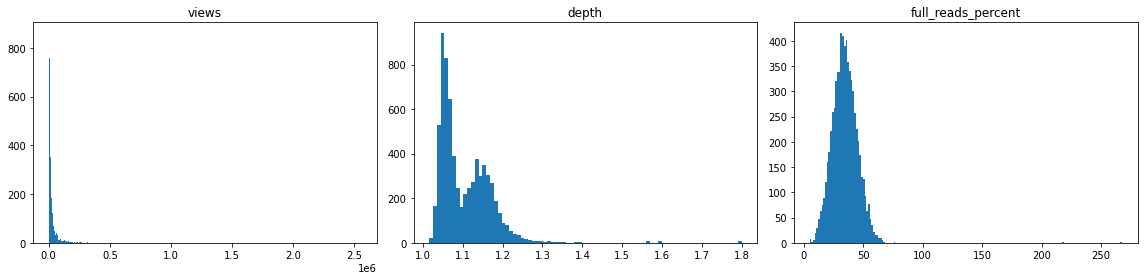

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
for i, col in enumerate(['views', 'depth', 'full_reads_percent']):
    axs[i].hist(df_train[col], bins='auto')
    axs[i].set_title(col)
plt.tight_layout()
plt.show()

Видно, что по всем целевым признакам есть выбросы или ошибки. По проценту прочтения есть значения с цифрой больше 100, глубина прочтения - бимодальное распределение. Количество просмотров - сильно асимметричное распределение

Глубину просмотров можно разделить с помощью GaussianMixture, просмотры - логарифмировать, на этапе анализа непонятно, пригодится это или нет.

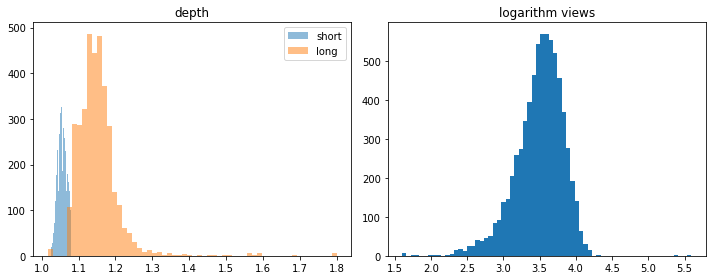

In [16]:
gmm = GaussianMixture(n_components=2, random_state=RANDOM_STATE)
depth_labels = gmm.fit_predict(df_train[['depth']])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

axs[0].hist(df_train.loc[depth_labels==0, 'depth'], bins='scott', label='short', alpha=.5)
axs[0].hist(df_train.loc[depth_labels==1, 'depth'], bins='scott', label='long', alpha=.5)
axs[0].set_title('depth')
axs[0].legend()
axs[1].hist(np.log(df_train[col]), bins='scott')
axs[1].set_title('logarithm views')

plt.tight_layout()
plt.show()

Задату последнего парсинга принял дату самой свежей новости. Посмотрим, как распределяются дни от парсинга до дат публикаций (есть 2 выброса, где статьям несколько лет, их исключим из анализа)

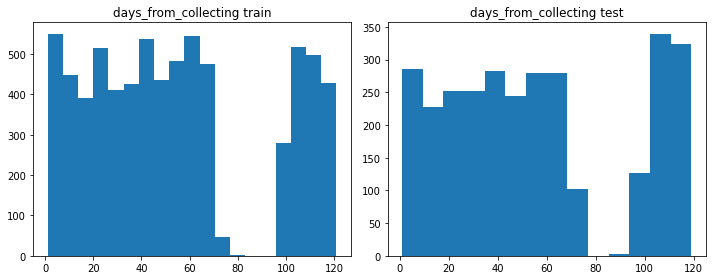

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

axs[0].hist(df_train.loc[df_train['days_from_collecting']<150, 'days_from_collecting'], bins='scott')
axs[1].hist(df_test.loc[df_test['days_from_collecting']<150, 'days_from_collecting'], bins='scott')
axs[0].set_title('days_from_collecting train')
axs[1].set_title('days_from_collecting test')

plt.tight_layout()
plt.show()

Из данных вырезан кусок, совпадающий с первым месяцем СВО. В оcтальном распределение схожее

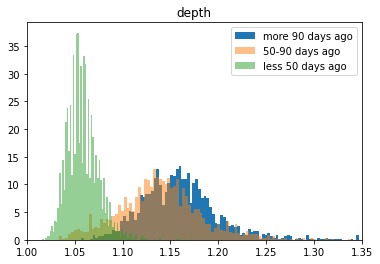

In [18]:
tgt = 'depth'
xlim = [1, 1.35]
cond = df_train[tgt] < xlim[1]
bins = 100
plt.hist(df_train.loc[cond & (df_train['days_from_collecting']>90), tgt], bins=bins, label='more 90 days ago', density=True)
plt.hist(df_train.loc[cond & df_train['days_from_collecting'].between(50,90), tgt], bins=bins, label='50-90 days ago', density=True, alpha=.5)
plt.hist(df_train.loc[cond & (df_train['days_from_collecting']<50), tgt], bins=bins, label='less 50 days ago', density=True, alpha=.5)
plt.xlim(xlim)
plt.legend()
plt.title(tgt)
plt.show()

Вырезанный кусок данных виден и на глубине прочтения. Возможно, такое распределение - просто итог вырезанного куска, возможно - это реальное смещение интересов в скрининг новостей.

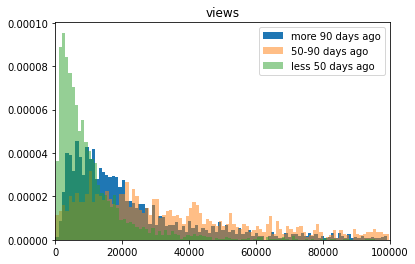

In [19]:
tgt = 'views'
xlim = [0, 10**5]
cond = df_train[tgt] < xlim[1]
bins = 100
plt.hist(df_train.loc[cond & (df_train['days_from_collecting']>90), tgt], bins=bins, label='more 90 days ago', density=True)
plt.hist(df_train.loc[cond & df_train['days_from_collecting'].between(50,90), tgt], bins=bins, label='50-90 days ago', density=True, alpha=.5)
plt.hist(df_train.loc[cond & (df_train['days_from_collecting']<50), tgt], bins=bins, label='less 50 days ago', density=True, alpha=.5)
plt.xlim(xlim)
plt.legend()
plt.title(tgt)
plt.show()

Посмотрим на повторяемости тегов, сессий, авторов и на то, будет ли походая картина при случайном разделении трейна на трейн и валидацию, или нужно дополнительно стратифицировать

In [20]:
_ = helpers.get_datasets_cat_intersection(df_train, df_test)

train unique_sessions_frac 84.30%
train unique_authors_frac 1.28%
train unique_tags_frac 19.60%

test unique_sessions_frac 90.60%
test unique_authors_frac 2.49%
test unique_tags_frac 29.26%

same_sessions 20.75%
same_authors 97.65%
same_tags 66.95%


In [21]:
test_size = df_test.shape[0] / (df_train.shape[0] + df_test.shape[0])
print('test_size', test_size)
train, val = train_test_split(df_train, test_size=test_size, random_state=RANDOM_STATE)
_ = helpers.get_datasets_cat_intersection(train, val)

test_size 0.3
train unique_sessions_frac 87.49%
train unique_authors_frac 1.73%
train unique_tags_frac 23.05%

test unique_sessions_frac 93.24%
test unique_authors_frac 3.75%
test unique_tags_frac 32.58%

same_sessions 17.57%
same_authors 94.38%
same_tags 64.47%


При случайном разбиении доли похожие, стратификация не обязательна

# Сохраняем результат

In [22]:
df_train.to_parquet(os.path.join(ROOT_ABSPATH, PREPARED_DATA_PATH, 'train.parquet'))
df_test.to_parquet(os.path.join(ROOT_ABSPATH, PREPARED_DATA_PATH, 'test.parquet'))

# Анализ интересных кейсов в данных

В датасетах есть очень схожие записи от разных дат на одинаковых url. Бывает, что немного меняется заголовок и текст, но общая суть новости сохраняется. Похоже, это связано с тем, что данные парсились в несколько заходов, а некоторые статьи обновлялись, незначительно менялись, оставаясь при этом на одном и том же url. У таких статей ссылка была одной и той же, были очень схожи ctr, заголовок (практически полностью, иногда за исключением постфикса (".... главное на сегодня", "...последние данные на 22 апреля" и т.д.) но менялась дата публикации. Популярность их, предположительно, также сохранялась и росла, не обнуляясь при обновлении текстов

Прогноз теста предварительно можно построить по следующей схеме:

1) простые эвристики: в доступной нам обучающей выборке ищем новости, схожие с рассматриваемой (по ctr и url, а также в перспективе поиск можно расширять на косинусное расстояние между заголовками и текстами статей и т.д.), если находим - прогнозируем её популярность усредненным значением по схожим новостям. Очевидно, что если ситуация, исход которой нужно спрогнозировать, уже происходила ранее (или происходило что-то очень похожее), то следует ожидать и исхода, как в предыдущий раз.

    В перспективе такой подход можно развить, он ускорит алгоритм (позволит перед запуском ml-моделей отфильтровывать новости и проч.): находим похожую новость (например, по расстоянию между эмбеддингами текста, заголовка, размещенную на таком же url и т.д.) - ожидаем похожую популярность.

2) прогнозируем оставшиеся записи (основная часть) с помощью ML-алгоритма
3) объединяем прогнозы в одну таблицу

In [23]:
print('\ntrain')
print('duplicated sum:', df_train.astype(str).duplicated().sum())
print('duplicated by title:', df_train.duplicated(subset=['title']).sum())
print('url_id duplicated:',df_train['url_id'].duplicated().sum())
print('url_id + title duplicated:', df_train[['url_id', 'title']].duplicated().sum())
print('url_id + title + views duplicated:', df_train[['url_id', 'title', 'views']].duplicated().sum())
print('\ntest')
print('duplicated sum:', df_test.astype(str).duplicated().sum())
print('duplicated by title:', df_test.duplicated(subset=['title']).sum())
print('url_id duplicated:',df_test['url_id'].duplicated().sum())
print('url_id + title duplicated:', df_test[['url_id', 'title']].duplicated().sum())

same_titles = set( df_train['title'] ) & set ( df_test['title'] )
print('\nsame train-test titles:', len(same_titles))

same_url = set( df_train['url_id'] ) & set( df_test['url_id'] )
print('same train-test urls:', len(same_url))

intersect_title_url = set( 
    df_train[['url_id', 'title']].apply(tuple, axis=1)
    ) & set( 
        df_test[['url_id', 'title']].apply(tuple, axis=1)
        )
print('same train-test urls + titles:', len(intersect_title_url))


train
duplicated sum: 0
duplicated by title: 66
url_id duplicated: 75
url_id + title duplicated: 61
url_id + title + views duplicated: 45

test
duplicated sum: 0
duplicated by title: 17
url_id duplicated: 20
url_id + title duplicated: 16

same train-test titles: 19
same train-test urls: 15
same train-test urls + titles: 17
